### Dogs vs Cats classification in Keras

In [1]:
#In Keras
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
import matplotlib.pyplot as plt
import os
import glob
%matplotlib inline

vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
train_dir = 'data/dogscats/cats_and_dogs/train'
valid_dir = 'data/dogscats/cats_and_dogs/validation'
test_dir = 'data/dogscats/cats_and_dogs/test'

print(len(glob.glob(os.path.join(train_dir, '*/*.jpg')))) #cats + dogs images in training data
print(len(glob.glob(os.path.join(valid_dir, '*/*.jpg')))) #cats + dogs images in validation data
print(len(glob.glob(os.path.join(test_dir, '*/*.jpg')))) #cats + dogs images in test data

/home/karen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


16000
5000
4000


#### Data Augmentation

In [2]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=30,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.1,
                                  zoom_range=0.1,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_gen = train_datagen.flow_from_directory(train_dir,
                                             target_size=(224,224),
                                             batch_size=32,
                                             class_mode='binary')


valid_gen = valid_datagen.flow_from_directory(valid_dir,
                                             target_size=(224,224),
                                             batch_size=32,
                                             class_mode='binary')

Found 16000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


#### Model Tuning

In [3]:
model = Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 27,560,769
Trainable params: 27,560,769
Non-trainable params: 0
_________________________________________________________________


In [4]:
vgg_model.trainable = True
set_trainable = False

#This unfreezes the last convolution layer so it can learn new weights when training
for layer in vgg_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

#### Compile and Run

In [5]:
model.compile(loss='binary_crossentropy',
             optimizer=optimizers.Adam(lr=2e-5),
             metrics=['accuracy'])

history = model.fit_generator(train_gen, 
                              epochs=20, 
                              validation_data=valid_gen,
                             validation_steps=50,
                             verbose=1)

model.save('cats_dogs_keras_vgg16.h5')

Epoch 1/20
500/500 [==============================] - 142s 283ms/step - loss: 0.2301 - acc: 0.8975 - val_loss: 0.1057 - val_acc: 0.9544
Epoch 2/20
500/500 [==============================] - 139s 278ms/step - loss: 0.1304 - acc: 0.9473 - val_loss: 0.1020 - val_acc: 0.9600
Epoch 3/20
500/500 [==============================] - 138s 276ms/step - loss: 0.1029 - acc: 0.9573 - val_loss: 0.0950 - val_acc: 0.9669
Epoch 4/20
500/500 [==============================] - 139s 278ms/step - loss: 0.0913 - acc: 0.9633 - val_loss: 0.0931 - val_acc: 0.9644
Epoch 5/20
500/500 [==============================] - 138s 275ms/step - loss: 0.0838 - acc: 0.9660 - val_loss: 0.0881 - val_acc: 0.9675
Epoch 6/20
500/500 [==============================] - 138s 277ms/step - loss: 0.0709 - acc: 0.9721 - val_loss: 0.0919 - val_acc: 0.9675
Epoch 7/20
500/500 [==============================] - 139s 279ms/step - loss: 0.0718 - acc: 0.9722 - val_loss: 0.0864 - val_acc: 0.9688
Epoch 8/20
500/500 [============================

#### Plot training information

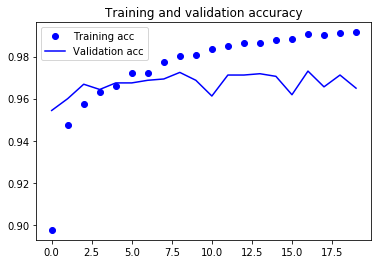

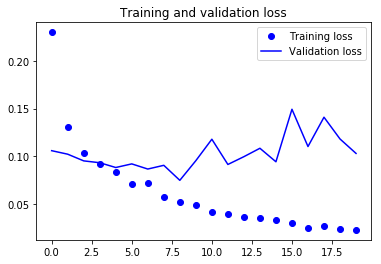

In [6]:
#Reference: https://github.com/fchollet/deep-learning-with-python-notebooks
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### Test model

In [7]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
            test_dir, 
            target_size=(224,224),
            batch_size=32, 
            class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_gen, steps=50)
print('Test accuracy: ', test_acc)

Found 4000 images belonging to 2 classes.
Test accuracy:  0.96375
